## **Train with DenseNet201**

# **Initialize**

**Import**

In [1]:
import sys
import tensorflow as tf

# Google Colab specific imports
from google.colab import drive
from google.colab.patches import cv2_imshow

# Package for DenseNet
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt

**Mount Google Drive**

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


**Variables**

In [3]:
# Global variables
train_generator = None
val_generator = None
model = None
base_model = None
class_names = None

# File paths
FULL_DATA_PATH = path_to_your_dataset

model_file_path = path_to_save_model
model_fint_tune_file_path = path_to_save_fine_tune_model

**Ensure GPU usage**

In [4]:
device_name = tf.test.gpu_device_name()
if device_name == "":
    print("GPU device not found. Please enable GPU in Colab runtime.")
else:
    print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


# **Data Preprocess**

In [10]:
def data_preprocess():
    global train_generator, val_generator, train_dataset, val_dataset, class_names

    dataset_path = FULL_DATA_PATH
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"), # Add horizontal and vertical randomness
        tf.keras.layers.RandomRotation(0.3),  # Add rotation randomness
        tf.keras.layers.RandomZoom(0.3),      # Add zoom randomness
        tf.keras.layers.RandomContrast(0.2),  # Add random contrast adjustments
        tf.keras.layers.RandomBrightness(0.2),  # Add random brightness adjustments
        tf.keras.layers.Resizing(224, 224),    # Resize back to target size
    ])

    # Load training dataset
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,  # Reserve 20% for validation
        subset="training",
        seed=23,  # Seed for reproducibility
        image_size=(224, 224),
        batch_size=32
    )

    # Extract and store class names
    class_names = train_dataset.class_names

    # Apply data augmentation and normalization to training dataset
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_generator = train_dataset.map(
        lambda x, y: (normalization_layer(data_augmentation(x)), y)
    )

    # Load validation dataset
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,  # Reserve 20% for validation
        subset="validation",
        seed=23,  # Seed for reproducibility
        image_size=(224, 224),
        batch_size=32
    )

    # Normalize validation dataset
    val_generator = val_dataset.map(
        lambda x, y: (normalization_layer(x), y)
    )

    # Prefetch datasets for improved performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_generator = train_generator.prefetch(buffer_size=AUTOTUNE)
    val_generator = val_generator.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_preprocess()

Found 77382 files belonging to 100 classes.
Using 69644 files for training.
Found 77382 files belonging to 100 classes.
Using 7738 files for validation.


# **Load Model**

### **Initialize model**

In [ ]:
def load_densenet201():
    global model, base_model, class_names
    # Load pre-trained DenseNet201 model, excluding top layers
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    # base_model.trainable = False

    base_model.trainable = True
    for layer in base_model.layers:
      if 'conv5' in layer.name:
        layer.trainable = True
      else:
        layer.trainable = False

    # Add new layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)  # Output layer

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
load_densenet201()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **load model to continue training**

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = path_to_the_model_you_want_to_keep_training
model = load_model(model_path)


# **Train model**

In [8]:
import numpy as np

In [ ]:
def model_train():
    global model, train_generator, val_generator, class_names

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(class_names),
        y=class_names
    )
    class_weights_dict = dict(enumerate(class_weights))

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.6, patience=2, verbose=1, min_lr=1e-5
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=10, restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        filepath=model_file_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[lr_scheduler, checkpoint],
        class_weight=class_weights_dict
    )
    return history

def model_eval():
    global model, val_generator
    loss, accuracy = model.evaluate(val_generator)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

accuracy: 0.0059 - loss: 7.2531
Validation Accuracy: 0.67%

In [ ]:
history = model_train()

Epoch 1/50
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.4313 - loss: 2.8622
Epoch 1: val_loss improved from inf to 1.26449, saving model to /content/drive/MyDrive/results/DensNet_full_2.keras
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 1148s 540ms/step - accuracy: 0.4314 - loss: 2.8619 - val_accuracy: 0.6899 - val_loss: 1.2645 - learning_rate: 0.0010
Epoch 2/50
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.6425 - loss: 1.5045
Epoch 2: val_loss improved from 1.26449 to 1.09248, saving model to /content/drive/MyDrive/results/DensNet_full_2.keras
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 850s 439ms/step - accuracy: 0.6425 - loss: 1.5045 - val_accuracy: 0.7368 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 3/50
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.6812 - loss: 1.3399
Epoch 3: val_loss improved from 1.09248 to 1.04700, saving model to /content/drive/MyDrive/results/DensNet_full_2.keras
1935/1935 ━━━━━━━━━━━━━━━━━━━━ 851s 440ms/step - accuracy: 0.6812 - loss: 1.339

# **Fine Tune**

242/242 ━━━━━━━━━━━━━━━━━━━━ 265s 978ms/step - accuracy: 0.8403 - loss: 0.6603
Validation Accuracy: 83.74%
Epoch 1/10
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8649 - loss: 0.4622
Epoch 1: val_loss improved from inf to 0.63649, saving model to /content/drive/MyDrive/results/DensNet_full_2_fine_tune.keras
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 2382s 1s/step - accuracy: 0.8649 - loss: 0.4623 - val_accuracy: 0.8328 - val_loss: 0.6365 - learning_rate: 1.0000e-04
Epoch 2/10
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8687 - loss: 0.4538
Epoch 2: val_loss improved from 0.63649 to 0.62870, saving model to /content/drive/MyDrive/results/DensNet_full_2_fine_tune.keras
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 940s 432ms/step - accuracy: 0.8687 - loss: 0.4538 - val_accuracy: 0.8338 - val_loss: 0.6287 - learning_rate: 1.0000e-04
Epoch 3/10
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8701 - loss: 0.4518
Epoch 3: val_loss improved from 0.62870 to 0.62377, saving model to /c

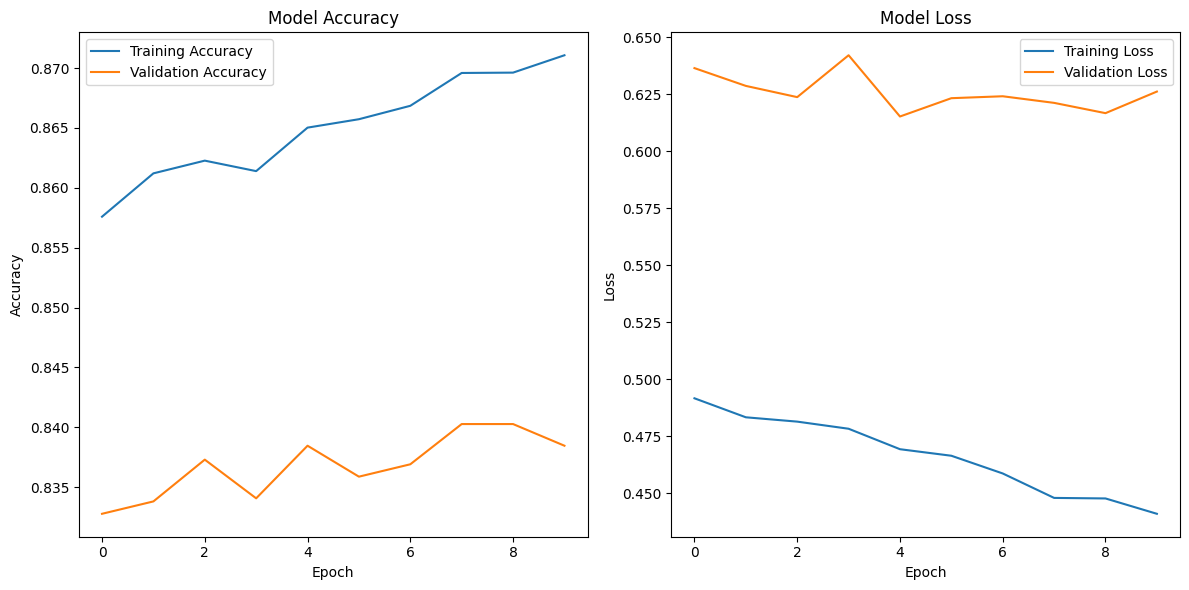

In [9]:
def model_fine_tune():
    global model, train_generator, val_generator, class_names

    # model.summary()
    # base_model.summary()
    # Unfreeze the last 5 layers of the base model

    model.trainable = True

    for layer in model.layers:
      if 'conv5' in layer.name:
        layer.trainable = True
      else:
        layer.trainable = False

    # Use a smaller learning rate to re-compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(class_names),
        y=class_names
    )
    class_weights_dict = dict(enumerate(class_weights))

    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.6, patience=2, verbose=1, min_lr=1e-5
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        filepath=model_fint_tune_file_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[lr_scheduler, checkpoint],
        class_weight=class_weights_dict
    )
    return history

def model_eval():
    global model, val_generator
    loss, accuracy = model.evaluate(val_generator)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


def plot_training_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

model_eval()
history = model_fine_tune()
plot_training_curves(history)